# **DL Assignment 4 - Sentimental Analysis**
## **DL Group 215**
###Nareskumar P (2020FC04122),
###Kommajyosula VNS Kanth (2020FC04120),
###Tejesh Dola (2020FC04459)

##Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from numpy import nan
import seaborn as sns
from google.colab import drive
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input, Embedding
from keras.regularizers import l2

#loading dataset into dataframe from colab
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/'
dataset= pd.read_csv('gdrive/My Drive/training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##Data Validation

In [2]:
dataset.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [3]:
#Verify gpu is running or not
tf.test.gpu_device_name()


'/device:GPU:0'

In [4]:
#Assigning column names to the data
dataset.columns =['target', 'id', 'date', 'flag', 'user', 'text']

In [5]:
dataset.head()

,target,id,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [6]:
dataset.describe()

,target,id
count,1.599999e+06,1.599999e+06
mean,2.000001e+00,1.998818e+09
std,2.000001e+00,1.935757e+08
min,0.000000e+00,1.467811e+09
25%,0.000000e+00,1.956916e+09
50%,4.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


In [7]:
dataset.target.unique()

array([0, 4])

We could see only 2 values present in the class feature ('target').

In [8]:
dataset.loc[dataset['target'] == 0]

,target,id,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
799994,0,2329205009,Thu Jun 25 10:28:28 PDT 2009,NO_QUERY,dandykim,Sick Spending my day laying in bed listening ...
799995,0,2329205038,Thu Jun 25 10:28:28 PDT 2009,NO_QUERY,bigenya,Gmail is down?
799996,0,2329205473,Thu Jun 25 10:28:30 PDT 2009,NO_QUERY,LeeLHoke,rest in peace Farrah! So sad
799997,0,2329205574,Thu Jun 25 10:28:30 PDT 2009,NO_QUERY,davidlmulder,@Eric_Urbane Sounds like a rival is flagging y...


In [9]:
dataset.loc[dataset['target'] == 4]

,target,id,date,flag,user,text
799999,4,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!
800000,4,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...
800001,4,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800002,4,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,Being sick can be really cheap when it hurts t...
800003,4,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone
...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


Count for 2 classes are balanced

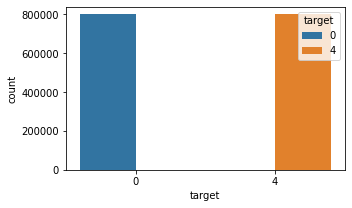

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 3))
sns.countplot(data=dataset, x='target', hue='target')
plt.show()

From the above bar chart, we could see two classes are having same amount of data 

In [11]:
dataset.shape

(1599999, 6)

##**Data Preprocessing and Cleaning**

In [12]:
dataset['text'] = dataset['text'].str.lower()

In [13]:
#Removing tags (starts with #) and mentions (starts with @) from the text feature
import re
dataset['text'] = dataset['text'].apply(lambda t: re.sub('@[^ ]+|#[^ ]+', '', t))

In [14]:
#Removing punctuations from the text
dataset['text'] = dataset['text'].str.replace('[^A-Za-z0-9 ]', "")

In [15]:
#loading english stop words library
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
dataset['text'] = dataset['text'].apply(lambda t: " ".join(word for word in t.split() if word not in stop))

In [17]:
dataset['text'][:5]

0    upset cant update facebook texting might cry r...
1    dived many times ball managed save 50 rest go ...
2                     whole body feels itchy like fire
3                             behaving im mad cant see
4                                           whole crew
Name: text, dtype: object

In [18]:
#Stemming the text
from nltk.stem import PorterStemmer
st = PorterStemmer()
dataset['text'].apply(lambda t: " ".join([st.stem(word) for word in t.split()]))

0          upset cant updat facebook text might cri resul...
1            dive mani time ball manag save 50 rest go bound
2                            whole bodi feel itchi like fire
3                                      behav im mad cant see
4                                                 whole crew
                                 ...                        
1599994                           woke school best feel ever
1599995    thewdbcom cool hear old walt interview httpbli...
1599996                         readi mojo makeov ask detail
1599997    happi 38th birthday boo alll time tupac amaru ...
1599998                                                happi
Name: text, Length: 1599999, dtype: object

In [19]:
#Lemmatization the text
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
dataset['text'] = dataset['text'].apply(lambda t: " ".join([wnl.lemmatize(word) for word in t.split()]))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [20]:
dataset['text'][:5]

0    upset cant update facebook texting might cry r...
1    dived many time ball managed save 50 rest go b...
2                      whole body feel itchy like fire
3                             behaving im mad cant see
4                                           whole crew
Name: text, dtype: object

##Splitting the data into Training and Testing

In [21]:
import tensorflow_hub as hub

x = dataset['text']
dataset['target'].replace({4 : 1}, inplace=True) #Replacing target values from 4 to 1

y = dataset.loc[ : ,'target'] #Using 'target' feature as classifier


#Splitting 80%/20% for training/testing the given dataset
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2, random_state=42)


In [22]:
dataset.loc[dataset['target'] == 1]

,target,id,date,flag,user,text
799999,1,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,love u guy r best
800000,1,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting one besties tonight cant wait girl ...
800001,1,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,thanks twitter add sunisa got meet hin show dc...
800002,1,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,sick really cheap hurt much eat real food plus...
800003,1,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,effect everyone
...,...,...,...,...,...,...
1599994,1,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,woke school best feeling ever
1599995,1,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,thewdbcom cool hear old walt interview httpbli...
1599996,1,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,ready mojo makeover ask detail
1599997,1,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,happy 38th birthday boo alll time tupac amaru ...


In [23]:
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((1279999,), (320000,), (1279999,), (320000,))

##Model 1 Building

In [24]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras import regularizers

hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2", input_shape=[], dtype=tf.string, trainable=True)
model = Sequential()
model.add(hub_layer)
model.add(Dense(512, activation='relu', kernel_regularizer = regularizers.l2(0.0001))) #Adding regularizers to avoid overfitting
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5)) # Added dropout to introduce more randomness since its a large neural network structure.
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid')) #Using sigmoid since our target value is binary classifier

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 dense (Dense)               (None, 512)               66048     
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 1)                 6

In [25]:
xtrain.head

<bound method NDFrame.head of 1441334                                 second get back haha
1169011                                    race life awesome
1480550    good clothes otherwise could even awkward alre...
790714     late work week dont even take metro guess bus ...
1247006                    incredible people need know worry
                                 ...                        
259178                                      didnt link wrong
1414414             yes mcfly twitter profile excellent idea
131932     know sometimes pretend superpower like say som...
671155                               cant believe came asked
121958                                             back bali
Name: text, Length: 1279999, dtype: object>

##Model Training

In [26]:
history = model.fit(xtrain,ytrain,epochs=20,batch_size=15000,validation_data=(xtest,ytest))

Epoch 1/20
86/86 [==============================] - 16s 173ms/step - loss: 0.5213 - accuracy: 0.7531 - val_loss: 0.4726 - val_accuracy: 0.7825
Epoch 2/20
86/86 [==============================] - 15s 171ms/step - loss: 0.4583 - accuracy: 0.7904 - val_loss: 0.4618 - val_accuracy: 0.7855
Epoch 3/20
86/86 [==============================] - 15s 170ms/step - loss: 0.4383 - accuracy: 0.8004 - val_loss: 0.4589 - val_accuracy: 0.7882
Epoch 4/20
86/86 [==============================] - 15s 170ms/step - loss: 0.4175 - accuracy: 0.8116 - val_loss: 0.4613 - val_accuracy: 0.7897
Epoch 5/20
86/86 [==============================] - 15s 170ms/step - loss: 0.3939 - accuracy: 0.8250 - val_loss: 0.4692 - val_accuracy: 0.7877
Epoch 6/20
86/86 [==============================] - 15s 170ms/step - loss: 0.3655 - accuracy: 0.8412 - val_loss: 0.4889 - val_accuracy: 0.7821
Epoch 7/20
86/86 [==============================] - 15s 169ms/step - loss: 0.3355 - accuracy: 0.8569 - val_loss: 0.5239 - val_accuracy: 0.7795

##Model Evaluation

In [27]:
#Determining Accuracy
loss, accuracy = model.evaluate(xtest, ytest, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.7561


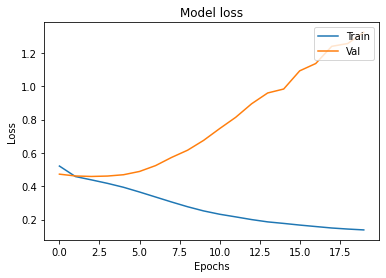

In [28]:
#Plotting the graph of Model loss for all epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

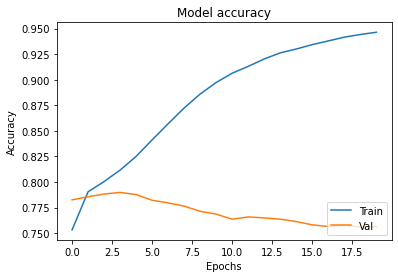

In [29]:
#Plotting the graph of the accuacy details for all epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

Confusion matrix and Classification report

In [31]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
y_pred_new = model.predict(xtest)
y_pred_nn = np.where(y_pred_new>0.5,1,0)
print("Accuracy:\n", accuracy_score(ytest, y_pred_nn))
print("Confusion Matrix:\n", confusion_matrix(ytest, y_pred_nn))
print("Classification Report:\n", classification_report(ytest, y_pred_nn))

Accuracy:
 0.756096875
Confusion Matrix:
 [[117844  41650]
 [ 36399 124107]]
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.74      0.75    159494
           1       0.75      0.77      0.76    160506

    accuracy                           0.76    320000
   macro avg       0.76      0.76      0.76    320000
weighted avg       0.76      0.76      0.76    320000



##Print the two most incorrectly classified records for each class in the test dataset.

In [35]:
# print the first 20 true and predicted responses
print('True', ytest.values[0:20])
print('Pred', y_pred_nn[0:20])

True [0 0 0 0 0 0 1 0 0 1 1 1 1 0 1 1 1 0 0 0]
Pred [[1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]]


From the above comparison, 1st and 17th record mismatched

In [36]:
#Mismatched records
print('Text','input_class', 'output_class')
print('Incorrectly Classfied Record 1: '+ xtest.iloc[0],ytest.iloc[0],y_pred_nn[0])
print('Incorrectly Classfied Record 2: '+ xtest.iloc[16],ytest.iloc[16],y_pred_nn[16])

Text input_class output_class
Incorrectly Classfied Record 1: poor little dumpling holmdel vids really tryinghope dont try hard tonight xx 0 [1]
Incorrectly Classfied Record 2: im feeling quite sleepy today wish could stay bed todaybut ok last year let go school 1 [0]


##Hyperparameter Tuning

###1. Regularization: Train a model without regularization

In [37]:
#. Regularization: Train a model without regularization
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2", input_shape=[], dtype=tf.string)
model2 = Sequential()
model2.add(hub_layer)
model2.add(Dense(512, activation='relu'))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5)) # Added dropout to introduce more randomness since its a large neural network structure.
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(1, activation='sigmoid')) #Using sigmoid since our target value is binary classifier

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense_5 (Dense)             (None, 512)               66048     
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 1)                

In [38]:
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [39]:
history2 = model2.fit(xtrain,ytrain,epochs=20,batch_size=15000,validation_data=(xtest,ytest))

Epoch 1/20
86/86 [==============================] - 7s 76ms/step - loss: 0.5666 - accuracy: 0.7044 - val_loss: 0.5304 - val_accuracy: 0.7329
Epoch 2/20
86/86 [==============================] - 6s 72ms/step - loss: 0.5228 - accuracy: 0.7377 - val_loss: 0.5145 - val_accuracy: 0.7426
Epoch 3/20
86/86 [==============================] - 6s 72ms/step - loss: 0.5108 - accuracy: 0.7462 - val_loss: 0.5084 - val_accuracy: 0.7469
Epoch 4/20
86/86 [==============================] - 6s 74ms/step - loss: 0.5040 - accuracy: 0.7505 - val_loss: 0.5040 - val_accuracy: 0.7499
Epoch 5/20
86/86 [==============================] - 6s 73ms/step - loss: 0.4985 - accuracy: 0.7544 - val_loss: 0.5016 - val_accuracy: 0.7513
Epoch 6/20
86/86 [==============================] - 7s 79ms/step - loss: 0.4945 - accuracy: 0.7571 - val_loss: 0.5012 - val_accuracy: 0.7514
Epoch 7/20
86/86 [==============================] - 6s 73ms/step - loss: 0.4911 - accuracy: 0.7591 - val_loss: 0.5003 - val_accuracy: 0.7523
Epoch 8/20
86

In [40]:
#Accuracy calculation
loss, accuracy = model.evaluate(xtest, ytest, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.7561


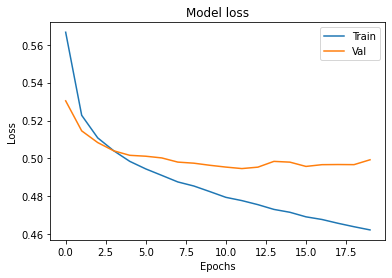

In [41]:
#Plotting the graph of Model loss for all epochs
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

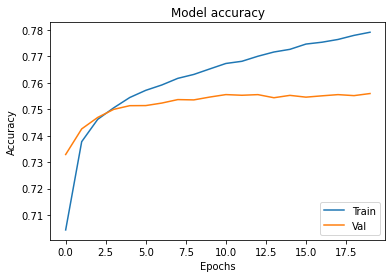

In [42]:
#Plotting the graph of the accuacy details for all epochs
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [43]:
y_pred_new = model2.predict(xtest)
y_pred_nn = np.where(y_pred_new>0.5,1,0)
print("Accuracy:\n", accuracy_score(ytest, y_pred_nn))
print("Confusion Matrix:\n", confusion_matrix(ytest, y_pred_nn))
print("Classification Report:\n", classification_report(ytest, y_pred_nn))

Accuracy:
 0.7559
Confusion Matrix:
 [[122091  37403]
 [ 40709 119797]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.77      0.76    159494
           1       0.76      0.75      0.75    160506

    accuracy                           0.76    320000
   macro avg       0.76      0.76      0.76    320000
weighted avg       0.76      0.76      0.76    320000



###2. Dropout:Change the position and value of dropout layer

In [44]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2", input_shape=[], dtype=tf.string)
model3 = Sequential()
model3.add(hub_layer)
model3.add(Dense(512, activation='relu', kernel_regularizer = regularizers.l2(0.0001)))
model3.add(Dense(256, activation='relu'))
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.3)) # Reduced the dropout value from 0.5 to 0.3 and also changed the position.
model3.add(Dense(64, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense_10 (Dense)            (None, 512)               66048     
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 1)                

In [45]:
model3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [46]:
history3 = model3.fit(xtrain,ytrain,epochs=20,batch_size=15000,validation_data=(xtest,ytest))

Epoch 1/20
86/86 [==============================] - 7s 75ms/step - loss: 0.5831 - accuracy: 0.7065 - val_loss: 0.5481 - val_accuracy: 0.7297
Epoch 2/20
86/86 [==============================] - 6s 72ms/step - loss: 0.5346 - accuracy: 0.7393 - val_loss: 0.5261 - val_accuracy: 0.7433
Epoch 3/20
86/86 [==============================] - 6s 72ms/step - loss: 0.5218 - accuracy: 0.7469 - val_loss: 0.5189 - val_accuracy: 0.7474
Epoch 4/20
86/86 [==============================] - 6s 71ms/step - loss: 0.5134 - accuracy: 0.7520 - val_loss: 0.5147 - val_accuracy: 0.7494
Epoch 5/20
86/86 [==============================] - 6s 71ms/step - loss: 0.5071 - accuracy: 0.7553 - val_loss: 0.5123 - val_accuracy: 0.7502
Epoch 6/20
86/86 [==============================] - 6s 72ms/step - loss: 0.5026 - accuracy: 0.7581 - val_loss: 0.5112 - val_accuracy: 0.7513
Epoch 7/20
86/86 [==============================] - 6s 70ms/step - loss: 0.4989 - accuracy: 0.7605 - val_loss: 0.5075 - val_accuracy: 0.7531
Epoch 8/20
86

In [47]:
#Accuracy Calculation
loss, accuracy = model.evaluate(xtest, ytest, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.7561


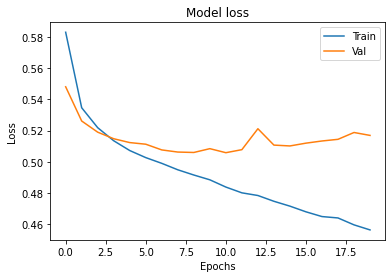

In [48]:
#Plotting the graph of Model loss for all epochs
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

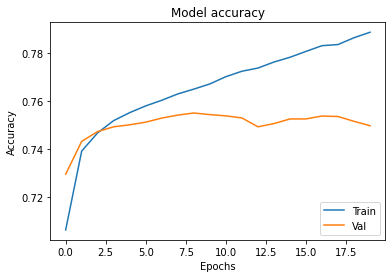

In [49]:
#Plotting the graph of the accuacy details for all epochs
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [50]:
y_pred_new = model3.predict(xtest)
y_pred_nn = np.where(y_pred_new>0.5,1,0)
print("Accuracy:\n", accuracy_score(ytest, y_pred_nn))
print("Confusion Matrix:\n", confusion_matrix(ytest, y_pred_nn))
print("Classification Report:\n", classification_report(ytest, y_pred_nn))

Accuracy:
 0.74985625
Confusion Matrix:
 [[126633  32861]
 [ 47185 113321]]
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.79      0.76    159494
           1       0.78      0.71      0.74    160506

    accuracy                           0.75    320000
   macro avg       0.75      0.75      0.75    320000
weighted avg       0.75      0.75      0.75    320000



##Conclusion:

Regularization helps to improve the reliability, speed and accuracy of convergence and its more important in model building. We have not used any regularization in Model 2 but we got accuracy of 75.6% and it is better than the Model 3.

Model 3 Dropout value is reduced from 0.5 to 0.3 and also changed its position. Dropout usually randomize the data while training hence it will increase the accuracy percentage after running more epochs. 

Model 3 has 74.9% accuracy whereas Model 2 has 75.6% accuracy. Some datasets perform good without regularization. Based on our observations, Model2 is better than Model3 for this dataset.